# Connect Google Drive

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

## Mount drive directory

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [237]:
import os
os.chdir("drive")

In [ ]:
!git clone https://github.com/merryHunter/iMaterialist-fashion-kaggle
os.chdir("iMaterialist-fashion-kaggle")
!ls # you should see here the repository files

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
kaggle competitions download -c imaterialist-challenge-fashion-2018

In [1]:
import torch
import torch.optim as optim
import json
import numpy as np
import cv2
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable

import os
from PIL import Image
from copy import deepcopy
%load_ext autoreload
%autoreload 2

In [238]:
DATA = "data/"
n_classes = 229 # n_classes + 1 (one class for all zeros in one hot encoding)
BATCH_SIZE = 10

# TODO: about data and encoding

In [191]:
class FashionDataset(Dataset):
    def __init__(self, json_path, img_path, set_type="train"):
        """
        Args:
            json_path (string): path to json file
            img_path (string): path to the folder where images are
            set_type: train or test , val is not supported yet
        """
        self.set_type = set_type
        self.to_tensor = transforms.ToTensor()
        self.data_info = json.loads(open(json_path).read())
        
        # read jsons
        arrr = [] # labels in one hot encoding,
        imgs = []
        names = []
        i = 0
        if set_type != "test":
            for ann in self.data_info['annotations']:
                imgs.append(os.path.join(img_path, ann['imageId'] + '.jpg'))
                names.append(ann['imageId'])
                label_arr = []
                label_arr =  np.sum([np.eye(n_classes, dtype="uint8")
                                     [ int(x)] for x in ann['labelId'] ], axis=0, dtype="uint8").tolist() 
                arrr.append(deepcopy(label_arr))

                i +=1
                if i == 10000:
                    break
        else:
            for ann in self.data_info['images']:
                imgs.append(os.path.join(img_path,str(ann['imageId']) + '.jpg'))
                names.append(ann['imageId'])
                
        self.names = names
        self.image_arr = imgs
        # Second column is the labels
        
#         self.label_arr = torch.stack(arrr) 
        if set_type != "test":
            self.label_arr = arrr 
        # Calculate len
        self.data_len = len(self.image_arr)
        self.transformations = transforms.Compose([transforms.Pad(8),transforms.CenterCrop(224),
                                transforms.ToTensor()])
            

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = Image.open(single_image_name)

        # Check if there is an operation
#         some_operation = self.operation_arr[index]
        # Transform image to tensor
        
#         img_as_tensor = self.to_tensor(img_as_img)
        img_as_tensor = self.transformations(img_as_img)  #
        
        
        if self.set_type == "test":
            return (img_as_tensor, self.names[index])
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        return (img_as_tensor, torch.FloatTensor(single_image_label), names)

    def __len__(self):
        return self.data_len

   

In [192]:
my_imgs =  FashionDataset(json_path='data/train.json',img_path="train/", set_type="train")
mn_dataset_loader = torch.utils.data.DataLoader(dataset=my_imgs,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)
my_test_imgs =  FashionDataset(json_path='data/test.json',img_path="test/", set_type="test")
test_dataset_loader = torch.utils.data.DataLoader(dataset=my_test_imgs,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)

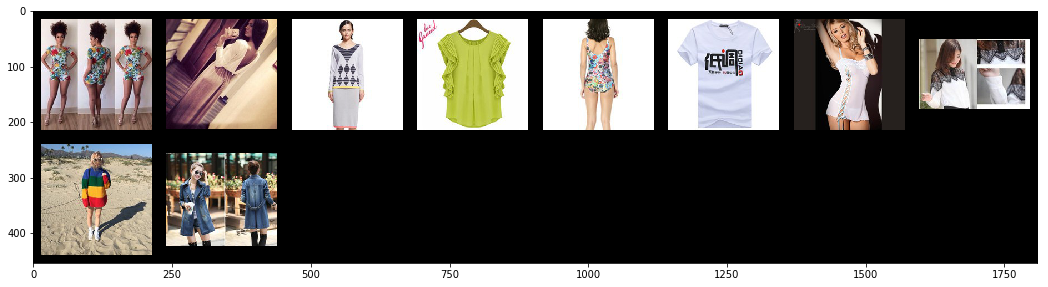

In [252]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
plt.figure(figsize=(18,12))

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg,(1, 2, 0)), interpolation='nearest', aspect='equal')


# get some random training images
dataiter = iter(mn_dataset_loader)
images, labels, _ = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

In [264]:
import squeezenet as sq
import torch.utils.model_zoo as model_zoo

squeezenet_1_1 = sq.model_urls['squeezenet1_1']

'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth'

In [268]:
!cd models
!wget https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth 
!cd ../

--2018-04-09 17:34:19--  https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth
Resolving download.pytorch.org (download.pytorch.org)... 52.85.173.158, 52.85.173.46, 52.85.173.100, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.173.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4966400 (4,7M) [application/octet-stream]
Saving to: ‘squeezenet1_1-f364aa15.pth.1’

squeezenet1_1-f364a 100%[===================>]   4,74M   258KB/s    in 19s     

2018-04-09 17:34:38 (254 KB/s) - ‘squeezenet1_1-f364aa15.pth.1’ saved [4966400/4966400]

--2018-04-09 17:34:38--  http://models/squeezenet1_1-f364aa15.pth
Resolving models (models)... failed: Name or service not known.
wget: unable to resolve host address ‘models’
FINISHED --2018-04-09 17:34:38--
Total wall clock time: 20s
Downloaded: 1 files, 4,7M in 19s (254 KB/s)


In [273]:
pretrained_dict = torch.load('models/squeezenet1_1-f364aa15.pth', map_location='cpu') # remove last param for gpu


In [292]:
model = sq.squeezenet1_1(num_classes=n_classes)

In [281]:
model_dict.pop('')

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.squeeze.weight', 'features.3.squeeze.bias', 'features.3.expand1x1.weight', 'features.3.expand1x1.bias', 'features.3.expand3x3.weight', 'features.3.expand3x3.bias', 'features.4.squeeze.weight', 'features.4.squeeze.bias', 'features.4.expand1x1.weight', 'features.4.expand1x1.bias', 'features.4.expand3x3.weight', 'features.4.expand3x3.bias', 'features.6.squeeze.weight', 'features.6.squeeze.bias', 'features.6.expand1x1.weight', 'features.6.expand1x1.bias', 'features.6.expand3x3.weight', 'features.6.expand3x3.bias', 'features.7.squeeze.weight', 'features.7.squeeze.bias', 'features.7.expand1x1.weight', 'features.7.expand1x1.bias', 'features.7.expand3x3.weight', 'features.7.expand3x3.bias', 'features.9.squeeze.weight', 'features.9.squeeze.bias', 'features.9.expand1x1.weight', 'features.9.expand1x1.bias', 'features.9.expand3x3.weight', 'features.9.expand3x3.bias', 'features.10.squeeze.weight', 'features.10.squeeze.bias', 'features.

In [282]:
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# remove last layer, as we have 229 labels, not 1000 as in ImageNet
pretrained_dict.pop('classifier.1.weight', None)
pretrained_dict.pop('classifier.1.bias', None)
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

In [287]:
j = 0
for param in model.parameters():
    param.requires_grad = False
    j+=1
    if j >= 48: # TODO
        param.requires_grad = True

In [293]:
criterion = torch.nn.MultiLabelSoftMarginLoss()
# filter out those without grad
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [ ]:
epochs = 1
i = 0
for epoch in range(epochs):
    losses = []
    for images, labels, _ in mn_dataset_loader:
        inputv = Variable(images)
        labelsv = Variable(torch.FloatTensor(labels))
        output = model(inputv)
        loss = criterion(output, labelsv)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.mean())
        if i % 100 == 0:
            print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, loss.data.mean()))
#             break
        i += 1
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(losses)))

[1/1] Loss: 0.960
[1/1] Loss: 0.959
[1/1] Loss: 0.923
[1/1] Loss: 0.700


In [182]:
preds = pd.read_csv("data/sample_submission.csv")
preds.head()

,image_id,label_id
0,1,106 115 126 145 161 176 185 32
1,2,115 13 14 158 18 184 190 220 227 44 47 56 81 9 92
2,3,104 112 129 224 31 83
3,4,113 121 145 150 218 63 77
4,5,1 126 167 170 196 208 213 216 22 32 48 54 79


In [200]:
label_ids = []

In [ ]:
i = 0

In [201]:
for images, names in test_dataset_loader:
    inputv = Variable(images)
    outputs = model(inputv)
    pred = torch.sigmoid(outputs).data > 0.5 # define threshold
    label_ids.extend(np.split(pred, 10))
    i += 1
    if i % 1000:
        print(i)

92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343


1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115


3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755


ValueError: array split does not result in an equal division

In [202]:
len(label_ids)

39700

In [204]:
last_pred = np.split(pred, 6)

In [205]:
label_ids.extend(last_pred)

In [235]:
preds['label_id']= pred_ids
preds.to_csv('sub-test.csv', index=False, header=True)

In [232]:
pred_ids = []
for label in label_ids:
    l = np.nonzero(label.numpy()[0])[0].tolist()
    o = ' '.join(str(x) for x in l)
    pred_ids.append(o)

In [221]:
label_ids[0].numpy()[0].argmax()

38

In [236]:
sub = pd.read_csv('sub-test.csv')
sub.head()

,image_id,label_id
0,1,38 40 45 60 66 87 88 94 114 119 123 128 137 14...
1,2,1 7 9 25 27 38 44 45 47 66 68 74 89 94 95 105 ...
2,3,2 7 19 33 38 45 61 66 67 70 92 94 108 111 114 ...
3,4,6 7 11 15 38 45 53 64 66 68 76 92 105 108 113 ...
4,5,45 54 63 68 87 88 89 92 94 110 112 119 120 134...
